Computing p-values from variable importance
=====================================

This is an *VariantSpark* example notebook.


One of the main applications of VariantSpark is discovery of genomic variants correlated with a response variable (e.g. case vs control) using random forest gini importance.

The `chr22_1000.vcf` is a very small sample of the chromosome 22 VCF file from the 1000 Genomes Project.

`chr22-labels-hail.csv` is a CSV file with sample response variables (labels). In fact the labels directly represent the number of alternative alleles for each sample at a specific genomic position. E.g.: column x22_16050408 has labels derived from variants in chromosome 22 position 16050408. We would expect then that position 22:16050408 in the VCF file is strongly correlated with the label x22_16050408.

Both data sets are located in the `..\data` directory.

This notebook demonstrates how to correctly get the p-values for each of the SNPs and their significant ones based on a *VariantSpark* model.

Step 1: Create a `HailContext` using `SparkContext` object (here injected as `sc`):

In [1]:
import hail as hl
import varspark.hail as vshl
from matplotlib import pyplot as plt
vshl.init()

using variant-spark jar at '/Users/szu004/dev/VariantSpark/target/variant-spark_2.11-0.5.0-a0-dev2-SNAPSHOT-all.jar'
22/07/06 12:34:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/07/06 12:34:55 WARN Hail: This Hail JAR was compiled for Spark 3.1.1, running with Spark 3.1.2.
  Compatibility is not guaranteed.
Running on Apache Spark version 3.1.2
SparkUI available at http://192.168.0.195:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.74-0c3a74d12093
LOGGING: writing to /Users/szu004/dev/VariantSpark/examples/hail-20220706-1234-0.2.74-0c3a74d12093.log


Step 2: Load Hail variant dataset  `vds` from a sample `.vcf` file.

In [2]:
vds = hl.import_vcf('../data/chr22_1000.vcf')

Step 3: Load labels into Hail table `labels`.

In [3]:
labels = hl.import_table('../data/chr22-labels-hail.csv', impute = True, delimiter=",").key_by('sample')

2022-07-06 12:34:58 Hail: WARN: Name collision: field 'sample' already in object dict. 
  This field must be referenced with __getitem__ syntax: obj['sample']
2022-07-06 12:34:58 Hail: INFO: Reading table to impute column types
2022-07-06 12:35:00 Hail: INFO: Finished type imputation
  Loading field 'sample' as type str (imputed)
  Loading field 'x22_16050408' as type int32 (imputed)
  Loading field 'x22_16050612' as type str (imputed)
  Loading field 'x22_16050678' as type str (imputed)
  Loading field 'x22_16050984' as type int32 (imputed)
  Loading field 'x22_16051107' as type int32 (imputed)
  Loading field 'x22_16051249' as type int32 (imputed)
  Loading field 'x22_16051347' as type int32 (imputed)
  Loading field 'x22_16051453' as type int32 (imputed)
  Loading field 'x22_16051477' as type int32 (imputed)
  Loading field 'x22_16051480' as type int32 (imputed)


Step 4: Annotate dataset samples with labels.

In [4]:
vds = vds.annotate_cols(label = labels[vds.s])
vds.cols().show(3)

2022-07-06 12:35:00 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'
2022-07-06 12:35:00 Hail: INFO: Coerced almost-sorted dataset
2022-07-06 12:35:01 Hail: INFO: Coerced sorted dataset


+-----------+--------------------+--------------------+--------------------+
| s         | label.x22_16050408 | label.x22_16050612 | label.x22_16050678 |
+-----------+--------------------+--------------------+--------------------+
| str       |              int32 | str                | str                |
+-----------+--------------------+--------------------+--------------------+
| "HG00096" |                  0 | "hahaha"           | "heheh"            |
| "HG00097" |                  1 | "ala ma"           | "1"                |
| "HG00099" |                  1 | "1"                | "1"                |
+-----------+--------------------+--------------------+--------------------+

+--------------------+--------------------+--------------------+
| label.x22_16050984 | label.x22_16051107 | label.x22_16051249 |
+--------------------+--------------------+--------------------+
|              int32 |              int32 |              int32 |
+--------------------+--------------------+--------------------+
|                  0 |                  0 |                  0 |
|                  0 |                  1 |                  1 |
|                  0 |                  1 |                  1 |
+--------------------+--------------------+--------------------+

+--------------------+--------------------+--------------------+
| label.x22_16051347 | label.x22_16051453 | label.x22_16051477 |
+--------------------+--------------------+--------------------+
|              int32 |              int32 |              int32 |
+--------------------+--------------------+--------------------+
|                  0 |                  0 |                  0 |
|                  1 |                  1 |                  0 |
|                  1 |                  1 |                  0 |
+--------------------+--------------------+--------------------+

+--------------------+
| label.x22_16051480 |
+--------------------+
|              int32 |
+--------------------+
|                  0 |
|                  1 |
|                  1 |
+--------------------+
showing top 3 rows

Step 5: Build the random forest model with `label.x22_16050408` as the respose variable.

In [5]:
rf_model = vshl.random_forest_model(y=vds.label['x22_16050408'],
                x=vds.GT.n_alt_alleles(), seed = 13, mtry_fraction = 0.05, min_node_size = 5, max_depth = 10)
rf_model.fit_trees(300, 50)

2022-07-06 12:35:01 Hail: INFO: Coerced almost-sorted dataset


Step 6: Display the results: print OOB error calculated variable importance.

In [6]:
print("OOB error: %s" % rf_model.oob_error())
impTable = rf_model.variable_importance()
impTable.order_by(hl.desc(impTable.importance)).show(10)

OOB error: 0.008241758241758242


2022-07-06 12:35:11 Hail: INFO: Coerced sorted dataset


,,,
locus,alleles,importance,splitCount
locus<GRCh37>,array<str>,float64,int64
22:16050408,"[""T"",""C""]",2.96e+01,209
22:16050678,"[""C"",""T""]",2.51e+01,125
22:16051480,"[""T"",""C""]",1.54e+01,84
22:16053509,"[""A"",""G""]",1.49e+01,48
22:16052838,"[""T"",""A""]",1.49e+01,65
22:16053197,"[""G"",""T""]",1.40e+01,54
22:16051882,"[""C"",""T""]",1.36e+01,68
22:16051107,"[""C"",""A""]",1.32e+01,64


Step 7: Get the fdr calculation class from the VariantSpark model

In [7]:
fdrCalc = rf_model.get_lfdr()

2022-07-06 12:35:12 Hail: INFO: Coerced sorted dataset


Step 8: Visualize the distribution of importances based on the number of splits for a variable to be included. These distributions can take many shapes but the goal here is that there is one big *unimodal distribution*. In this case, setting the threshold to `2` looks the best.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


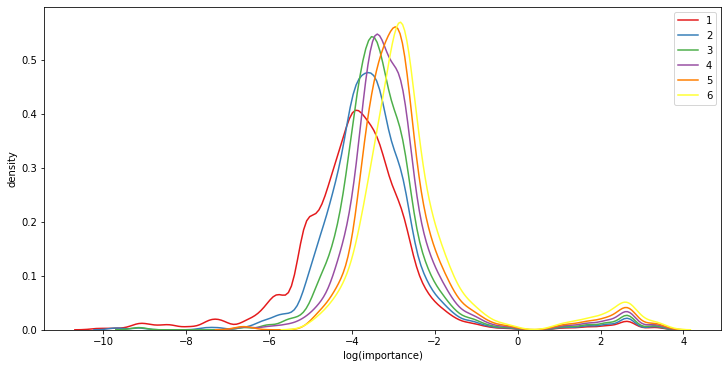

In [8]:
fig, ax1 = plt.subplots(figsize=(10, 5), layout='constrained')
fdrCalc.plot_log_densities(ax1, min_split_count=1, max_split_count=6, find_automatic_best=False)
plt.show()

Step 9: This is a sanity check to visualize the splitcount was correct and consistent. (optional)

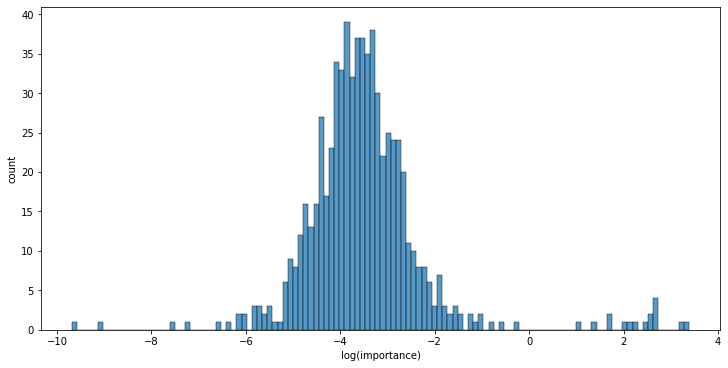

In [9]:
fig, ax2 = plt.subplots(figsize=(10, 5), layout='constrained')
fdrCalc.plot_log_hist(ax2, split_count=2)
plt.show()

Step 10: Compute the p-values, their significance, and the expected false discovery rate (FDR).

In [10]:
pvalsDF, fdr = fdrCalc.compute_fdr(countThreshold = 2, local_fdr_cutoff = 0.05)
pvalsDF, fdr

(           variant_id  logImportance        pvalue  is_significant
 0     22_17705196_C_G      -9.685114  1.000000e+00           False
 1     22_17685358_C_T      -9.134216  1.000000e+00           False
 2    22_17774329_TC_T      -7.530889  9.999952e-01           False
 3     22_17763349_T_A      -7.214255  9.999780e-01           False
 4     22_17691887_C_T      -6.603883  9.996942e-01           False
 ..                ...            ...           ...             ...
 682   22_16052838_T_A       2.698982  0.000000e+00            True
 683   22_16053509_A_G       2.703196  2.220446e-16            True
 684   22_16051480_T_C       2.732347  2.220446e-16            True
 685   22_16050678_C_T       3.224218  1.110223e-16            True
 686   22_16050408_T_C       3.387460  1.110223e-16            True
 
 [687 rows x 4 columns],
 0.000997620934933333)

Step 11: Visualize that the distribution (purple bars), fits the fitted distribution (red line). The "C" (orange) should fall on the right of the red distribution. And the local fdr (blue) crossing the black line (cutoff threshold) is on the right from 'C'. (optional but encouraged)

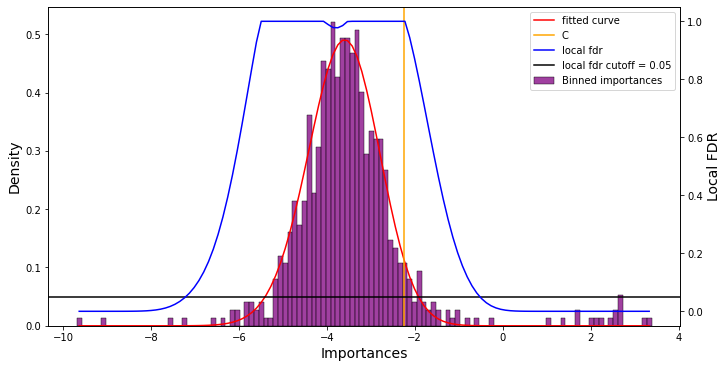

In [11]:
fig, ax3 = plt.subplots(figsize=(10, 5), layout='constrained')
fdrCalc.plot(ax3)
plt.show()

In [12]:
hl.stop()